Completed Testing

import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sys

from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, recall_score
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, sub_folder, transform, data_type='original'):
        self.root_dir = root_dir
        self.sub_folder = sub_folder
        self.transform = transform
        self.data_type = data_type
        self.image_paths = []
        self.labels = []
        self.sources = []

        if self.data_type == 'original':
            self.load_original_data()
        elif self.data_type == 'augmentation':
            self.load_augmented_data()

    # Iterate through the video folders
    def load_original_data(self):
        label_file = os.path.join(root_dir, 'old + new image frames.xlsx')
        numVideos = 0
        for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
            if os.path.isdir(os.path.join(root_dir, sub_folder, video_folder)):
                video_path = os.path.join(root_dir, sub_folder, video_folder)
                try:
                    labels_df = pd.read_excel(label_file, sheet_name=f'{video_folder}')
                    print(f"Processing video folder: {video_folder}")
                    numVideos += 1
                except ValueError:
                    # If the sheet does not exist, skip this folder and continue with the next
                    continue

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)
                        root, ext = os.path.splitext(img_filename)  # Split xxx_0.jpg into root and extension
                        frame_idx = int(root.split('_')[-1]) #splitting xxx_0 and storing 0 to frame_idx
                        labels = labels_df.loc[frame_idx, ['BAD QUALITY','CORD','FLUID']].values.astype('float32').squeeze()
                        source = labels_df.loc[frame_idx, 'SOURCE']

                        self.image_paths.append(img_path)
                        self.labels.append(labels)
                        self.sources.append(source)
        print(f"Number of videos: {numVideos}")

    def load_augmented_data(self):
        for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
            if os.path.isdir(os.path.join(root_dir, sub_folder, video_folder)):
                video_path = os.path.join(root_dir, sub_folder, video_folder)
                label_file = os.path.join(root_dir, 'Label',f'{video_folder}.xlsx')
                labels_df = pd.read_excel(label_file)

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)
                        root, ext = os.path.splitext(img_filename)  # Split 0.jpg_xxxxx.jpg into root and extension
                        labels = labels_df.loc[labels_df['FILENAME']==img_filename, ['BAD QUALITY','CORD','FLUID']].values.astype('float32').squeeze()
                        source = labels_df.loc[labels_df['FILENAME'] == img_filename, 'SOURCE'].values[0]

                        self.image_paths.append(img_path)
                        self.labels.append(labels)
                        self.sources.append(source)


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.labels[idx]
        source = self.sources[idx]

        if self.transform:
            image = self.transform(image)

        return image, labels, source


# Function to calculate mean and standard deviation of the dataset
def calculate_mean_std(loader):
    # Placeholder for mean and standard deviation
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, *_ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images.size(0)

    mean /= total_images_count
    std /= total_images_count
    return mean, std

# Online calculation of mean and std with device management
def calculate_mean_std_online(data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move initial total_mean and total_var tensors to the same device
    total_mean = torch.zeros(3, device=device)
    total_var = torch.zeros(3, device=device)
    total_images = 0

    for images, *_ in data_loader:
        images = images.to(device)
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        batch_mean = images.mean(2).sum(0)
        batch_var = images.var(2).sum(0)

        total_mean += batch_mean
        total_var += batch_var
        total_images += batch_samples

    mean = total_mean / total_images
    std = torch.sqrt(total_var / total_images)
    return mean.cpu(), std.cpu()  # Return to CPU for further use if necessary

def calculate_source_distribution(subset):
    sources = [source for _, _, source in subset]
    source_0_count = sources.count(0)
    source_1_count = sources.count(1)
    return source_0_count, source_1_count

# Initialize Dataset and Dataloader with placeholder transforms to calculate mean and std
def initialize_data(root_dir, sub_folder, data_type='original'):
    # Placeholder transform to convert images to tensors
    transform_placeholder = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    train_dataset = CustomDataset(root_dir, sub_folder=sub_folder, transform=transform_placeholder, data_type=data_type)

    # Use random_split to split the dataset
    total_size = len(train_dataset)
    train_size = int(0.70 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size
    train_subset, val_subset, test_subset = random_split(train_dataset, [train_size, val_size, test_size])

    # Create a temporary DataLoader for the train subset to calculate mean and std
    batch_size = 64
    train_loader_temp = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    # Calculate mean and std on the train set
    mean, std = calculate_mean_std_online(train_loader_temp)
    print(f"Calculated mean: {mean}")
    print(f"Calculated std: {std}")
    print()

    # Define transform with calculated normalization values
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])

    # Re-initialize datasets with the new transform
    train_dataset = CustomDataset(root_dir, sub_folder=sub_folder, transform=transform, data_type=data_type)
    train_subset, val_subset, test_subset = random_split(train_dataset, [train_size, val_size, test_size])

    train_source_0, train_source_1 = calculate_source_distribution(train_subset)
    val_source_0, val_source_1 = calculate_source_distribution(val_subset)
    test_source_0, test_source_1 = calculate_source_distribution(test_subset)

    # Create data loaders with normalized transform for each subset
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    print('Data Size: train:', len(train_loader.dataset), 'val:', len(val_loader.dataset), 'test:', len(test_loader.dataset))
    print(f"Source distribution in train set: 0: {train_source_0}, 1: {train_source_1}")
    print(f"Source distribution in val set: 0: {val_source_0}, 1: {val_source_1}")
    print(f"Source distribution in test set: 0: {test_source_0}, 1: {test_source_1}")

    return train_loader, val_loader, test_loader

In [3]:
# Define Model
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.resnet(x)

In [4]:
# Train Model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    global num_classes
    global device
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        # Initialize loss and accuracy variables for this epoch
        running_loss = 0.0
        correct_predictions = 0

        # Initialize the progress bar
        train_progress_bar = tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        for images, labels, _ in train_progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            predicts = (outputs > 0.5).float()
            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss = loss.item()
            running_loss += train_loss * images.size(0)
            correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            train_progress_bar.set_postfix({'Batch Loss': train_loss, 'Batch Accuracy': acc})
            torch.save(model, "saved_model.pt")

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Save the state of the model
        torch.save(model.state_dict(), "saved_model_state.pt")
        torch.save(model, "saved_model.pt")

        ######################### Validation loop
        print('Validation:')
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0

        # Initialize the progress bar for validation
        val_progress_bar = tqdm(val_loader, total=len(val_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        with torch.no_grad():
            for images, labels, _ in val_progress_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicts = (outputs > 0.5).float()
                acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
                loss = criterion(outputs, labels)

                val_loss = loss.item()
                val_running_loss += val_loss * images.size(0)
                val_correct_predictions += acc * images.size(0)

                # Update the progress bar with the loss and accuracy
                val_progress_bar.set_postfix({'Batch Loss': val_loss, 'Batch Accuracy': acc})
        # Calculate average loss and accuracy for the validation
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = val_correct_predictions / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        print(f'Validation Epoch {epoch+1}/{num_epochs} - Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}')
        print('------------------------------------------------------------------------------------------------')

    return train_losses, train_accuracies, val_losses, val_accuracies

def plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies):
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Epoch vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

In [5]:
# Load Model
def load_model(model_path):
    # Load the saved model
    model = torch.load(model_path)
    model.eval()  # Set the model to evaluation mode
    return model

In [6]:
# Test Model
def test_model(test_loader, model_path, criterion):
    global num_classes
    global device
    # Initialize variables to store predictions and true labels

    # Load the model
    model = load_model(model_path)

    all_preds = []
    all_labels = []

    # Test loop
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct_predictions = 0

    # Initialize the progress bar for testing
    test_progress_bar = tqdm(test_loader, total=len(test_loader), desc='Testing', position=0, leave=True)

    misclassified_images = []

    with torch.no_grad():
        image_index = 0
        for images, labels, _ in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicts = (outputs > 0.5).float()

            #Check for misclassifications
            for idx, (pred, true) in enumerate(zip(predicts, labels)):
                if not torch.equal(pred, true):
                    misclassified_images.append({
                        'image_index': image_index + idx,
                        'predicted_labels': pred.cpu().numpy(),
                        'true_labels': true.cpu().numpy()
                    })

            # ... [rest of your existing code in the loop] ...
            # Store predictions and true labels for later metrics calculation
            all_preds.extend(predicts.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)

            test_loss = loss.item()
            test_running_loss += test_loss * images.size(0)
            test_correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            test_progress_bar.set_postfix({'Batch Loss': test_loss, 'Batch Accuracy': acc})

            image_index += images.size(0)

    # Calculate average loss and accuracy for the test set
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_accuracy = test_correct_predictions / len(test_loader.dataset)

    # Calculate other metrics
    precision = precision_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    recall = recall_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    f1 = f1_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    roc_auc = roc_auc_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    tn, fp, fn, tp = confusion_matrix(np.array(all_labels).flatten(), np.array(all_preds).flatten()).ravel()

    print("\n" + "="*50)
    print(f'Test Metrics:')
    print(f'{"-"*50}')
    print(f'Loss      : {test_epoch_loss:.4f}')
    print(f'Accuracy  : {test_epoch_accuracy:.4f}')
    print(f'Precision : {precision:.4f}')
    print(f'Recall    : {recall:.4f}')
    print(f'True Negatives : {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print(f'True Positives : {tp}')
    print(f'F1 Score  : {f1:.4f}')
    print(f'ROC AUC   : {roc_auc:.4f}')
    print("="*50)

    # Initialize variables to store class-wise metrics
    class_precisions = []
    class_recalls = []
    class_f1s = []
    class_roc_aucs = []

    # Calculate metrics for each class
    num_classes = np.array(all_labels).shape[1]  # Assuming all_labels is a 2D array
    for i in range(num_classes):
        y_true = np.array(all_labels)[:, i]
        y_pred = np.array(all_preds)[:, i]

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1)
        class_roc_aucs.append(roc_auc)

        print(f"Metrics for class {i}:")
        print(f"  Precision : {precision:.4f}")
        print(f"  Recall    : {recall:.4f}")
        print(f"  F1 Score  : {f1:.4f}")
        print(f"  ROC AUC   : {roc_auc:.4f}")
        print(f'True Negatives : {tn}')
        print(f'False Positives: {fp}')
        print(f'False Negatives: {fn}')
        print(f'True Positives : {tp}')
        print("-"*20)

    # If you want a summary report
    print("Summary Classification Report:")
    print(classification_report(np.array(all_labels), np.array(all_preds), zero_division=0))

    # Print or return the misclassified images
    print(f"Total Misclassified Images: {len(misclassified_images)}")
    for misclassified in misclassified_images:
        print(f"Image Index: {misclassified['image_index']}, Predicted Labels: {misclassified['predicted_labels']}, True Labels: {misclassified['true_labels']}")

    return all_labels, all_preds, misclassified_images

In [7]:
# Main function to run the whole pipeline
def main(root_dir, sub_folder, model, criterion, optimizer, num_epochs, data_type='original'):
    # Initialize Data
    train_loader, val_loader, test_loader = initialize_data(root_dir, sub_folder, data_type=data_type)
    #check_loaders(train_loader, val_loader, test_loader)

    '''global device
    model = CustomResNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)'''

    # Train Model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies)

    # Test Model
    all_labels, all_preds = test_model(test_loader, model, criterion)


In [8]:
import matplotlib.pyplot as plt

def show_images(images, labels=None, num_images=4):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axs[i].imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        axs[i].axis('off')
        if labels is not None:
            axs[i].set_title(labels[i])

def check_loaders(train_loader, val_loader, test_loader):
    print("Train Loader: {} batches ({} images)".format(len(train_loader), len(train_loader.dataset)))
    print("Validation Loader: {} batches ({} images)".format(len(val_loader), len(val_loader.dataset)))
    print("Test Loader: {} batches ({} images)".format(len(test_loader), len(test_loader.dataset)))

    # Optionally, visualize some images from each loader
    for images, labels, _ in train_loader:
        show_images(images)
        break  # Just show the first batch

In [9]:
#train-valid-test
def tvt(train_loader, val_loader, test_loader, model, criterion, optimizer, num_epochs):

    # Train Model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies)

    # Test Model
    all_labels, all_preds = test_model(test_loader, model, criterion)


In [10]:
# Initialize Data
root_dir = '/content/drive/MyDrive/Capstone: CV for Infant Lumbar Puncture/Data Files'    # CHANGE BASED ON FOLDER LOCATION
sub_folder = 'Old + New Video Frames'
num_classes=3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
org_train_loader, org_val_loader, org_test_loader = initialize_data(root_dir,
                                                                    sub_folder,
                                                                    data_type='original')

Processing video folder: 01.09.31 hrs __0025097
Processing video folder: 01.09.47 hrs __0025098
Processing video folder: AM12 (Converted)
Processing video folder: BM12 (Converted)
Processing video folder: LP SONO 001 POST FNL CONUS
Processing video folder: LP SONO 001 POST FST CONUS
Processing video folder: LPPILOTLAT1
Processing video folder: LPPILOTLAT2
Processing video folder: LPPILOTLAT3
Processing video folder: LPPILOTSITTING2
Processing video folder: US00000L
Processing video folder: XM12 (Converted)
Processing video folder: YM12 (Converted)
Processing video folder: 200106061016030017SMP_crop
Processing video folder: 200106061016340018SMP_crop
Processing video folder: 200106061016530019SMP_crop
Processing video folder: 200106061017230020SMP_crop
Processing video folder: 202402091355160039ABD_crop
Processing video folder: 202402091355230040ABD_crop
Processing video folder: 202402091355350041ABD_crop
Processing video folder: 202402091355470042ABD_crop
Processing video folder: 20240

In [11]:
from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F

Epoch 1: 100%|██████████| 90/90 [00:45<00:00,  1.99it/s, Batch Loss=0.0299, Batch Accuracy=1]


Epoch 1/20 - Loss: 0.1698, Accuracy: 0.9314
Validation:


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, Batch Loss=0.105, Batch Accuracy=0.971]


Validation Epoch 1/20 - Loss: 0.0891, Accuracy: 0.9689
------------------------------------------------------------------------------------------------


Epoch 2: 100%|██████████| 90/90 [00:44<00:00,  2.03it/s, Batch Loss=1.37, Batch Accuracy=0.667]


Epoch 2/20 - Loss: 0.0604, Accuracy: 0.9802
Validation:


Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s, Batch Loss=0.0363, Batch Accuracy=0.986]


Validation Epoch 2/20 - Loss: 0.0823, Accuracy: 0.9746
------------------------------------------------------------------------------------------------


Epoch 3: 100%|██████████| 90/90 [00:44<00:00,  2.02it/s, Batch Loss=0.476, Batch Accuracy=0.667]


Epoch 3/20 - Loss: 0.0521, Accuracy: 0.9828
Validation:


Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, Batch Loss=0.127, Batch Accuracy=0.957]


Validation Epoch 3/20 - Loss: 0.1843, Accuracy: 0.9574
------------------------------------------------------------------------------------------------


Epoch 4: 100%|██████████| 90/90 [00:43<00:00,  2.06it/s, Batch Loss=0.163, Batch Accuracy=1]


Epoch 4/20 - Loss: 0.0566, Accuracy: 0.9800
Validation:


Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s, Batch Loss=0.119, Batch Accuracy=0.971]


Validation Epoch 4/20 - Loss: 0.1894, Accuracy: 0.9681
------------------------------------------------------------------------------------------------


Epoch 5: 100%|██████████| 90/90 [00:43<00:00,  2.08it/s, Batch Loss=0.0111, Batch Accuracy=1]


Epoch 5/20 - Loss: 0.0410, Accuracy: 0.9853
Validation:


Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.28it/s, Batch Loss=0.0281, Batch Accuracy=0.986]


Validation Epoch 5/20 - Loss: 0.0517, Accuracy: 0.9853
------------------------------------------------------------------------------------------------


Epoch 6: 100%|██████████| 90/90 [00:43<00:00,  2.06it/s, Batch Loss=5.03, Batch Accuracy=0.333]


Epoch 6/20 - Loss: 0.0234, Accuracy: 0.9920
Validation:


Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, Batch Loss=0.0325, Batch Accuracy=0.986]


Validation Epoch 6/20 - Loss: 0.0384, Accuracy: 0.9844
------------------------------------------------------------------------------------------------


Epoch 7: 100%|██████████| 90/90 [00:44<00:00,  2.01it/s, Batch Loss=1.25, Batch Accuracy=0.667]


Epoch 7/20 - Loss: 0.0403, Accuracy: 0.9878
Validation:


Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.36it/s, Batch Loss=0.0462, Batch Accuracy=0.986]


Validation Epoch 7/20 - Loss: 0.0200, Accuracy: 0.9926
------------------------------------------------------------------------------------------------


Epoch 8: 100%|██████████| 90/90 [00:43<00:00,  2.05it/s, Batch Loss=0.231, Batch Accuracy=1]


Epoch 8/20 - Loss: 0.0232, Accuracy: 0.9944
Validation:


Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, Batch Loss=0.0159, Batch Accuracy=0.986]


Validation Epoch 8/20 - Loss: 0.0290, Accuracy: 0.9894
------------------------------------------------------------------------------------------------


Epoch 9: 100%|██████████| 90/90 [00:43<00:00,  2.06it/s, Batch Loss=4.12, Batch Accuracy=0.333]


Epoch 9/20 - Loss: 0.0225, Accuracy: 0.9931
Validation:


Epoch 9: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, Batch Loss=0.015, Batch Accuracy=1]


Validation Epoch 9/20 - Loss: 0.0449, Accuracy: 0.9853
------------------------------------------------------------------------------------------------


Epoch 10: 100%|██████████| 90/90 [00:44<00:00,  2.03it/s, Batch Loss=0.0198, Batch Accuracy=1]


Epoch 10/20 - Loss: 0.0428, Accuracy: 0.9878
Validation:


Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, Batch Loss=0.0814, Batch Accuracy=0.986]


Validation Epoch 10/20 - Loss: 0.0352, Accuracy: 0.9910
------------------------------------------------------------------------------------------------


Epoch 11: 100%|██████████| 90/90 [00:44<00:00,  2.05it/s, Batch Loss=1.32, Batch Accuracy=0.667]


Epoch 11/20 - Loss: 0.0205, Accuracy: 0.9927
Validation:


Epoch 11: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s, Batch Loss=0.0406, Batch Accuracy=0.986]


Validation Epoch 11/20 - Loss: 0.0407, Accuracy: 0.9853
------------------------------------------------------------------------------------------------


Epoch 12: 100%|██████████| 90/90 [00:44<00:00,  2.02it/s, Batch Loss=0.201, Batch Accuracy=1]


Epoch 12/20 - Loss: 0.0248, Accuracy: 0.9926
Validation:


Epoch 12: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s, Batch Loss=0.0532, Batch Accuracy=0.986]


Validation Epoch 12/20 - Loss: 0.0275, Accuracy: 0.9918
------------------------------------------------------------------------------------------------


Epoch 13: 100%|██████████| 90/90 [00:44<00:00,  2.03it/s, Batch Loss=1.17, Batch Accuracy=0.667]


Epoch 13/20 - Loss: 0.0165, Accuracy: 0.9952
Validation:


Epoch 13: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, Batch Loss=0.0765, Batch Accuracy=0.986]


Validation Epoch 13/20 - Loss: 0.0329, Accuracy: 0.9934
------------------------------------------------------------------------------------------------


Epoch 14: 100%|██████████| 90/90 [00:44<00:00,  2.02it/s, Batch Loss=0.334, Batch Accuracy=0.667]


Epoch 14/20 - Loss: 0.0172, Accuracy: 0.9938
Validation:


Epoch 14: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s, Batch Loss=0.0468, Batch Accuracy=0.986]


Validation Epoch 14/20 - Loss: 0.1311, Accuracy: 0.9853
------------------------------------------------------------------------------------------------


Epoch 15: 100%|██████████| 90/90 [00:44<00:00,  2.02it/s, Batch Loss=0.00492, Batch Accuracy=1]


Epoch 15/20 - Loss: 0.0178, Accuracy: 0.9946
Validation:


Epoch 15: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s, Batch Loss=0.101, Batch Accuracy=0.986]


Validation Epoch 15/20 - Loss: 0.0233, Accuracy: 0.9934
------------------------------------------------------------------------------------------------


Epoch 16: 100%|██████████| 90/90 [00:43<00:00,  2.05it/s, Batch Loss=0.00415, Batch Accuracy=1]


Epoch 16/20 - Loss: 0.0127, Accuracy: 0.9956
Validation:


Epoch 16: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s, Batch Loss=0.0338, Batch Accuracy=0.986]


Validation Epoch 16/20 - Loss: 0.0207, Accuracy: 0.9910
------------------------------------------------------------------------------------------------


Epoch 17: 100%|██████████| 90/90 [00:44<00:00,  2.02it/s, Batch Loss=0.00367, Batch Accuracy=1]


Epoch 17/20 - Loss: 0.0066, Accuracy: 0.9984
Validation:


Epoch 17: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, Batch Loss=0.0722, Batch Accuracy=0.986]


Validation Epoch 17/20 - Loss: 0.0096, Accuracy: 0.9975
------------------------------------------------------------------------------------------------


Epoch 18: 100%|██████████| 90/90 [00:44<00:00,  2.04it/s, Batch Loss=2.23, Batch Accuracy=0.667]


Epoch 18/20 - Loss: 0.0042, Accuracy: 0.9987
Validation:


Epoch 18: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, Batch Loss=0.0154, Batch Accuracy=1]


Validation Epoch 18/20 - Loss: 0.0259, Accuracy: 0.9902
------------------------------------------------------------------------------------------------


Epoch 19: 100%|██████████| 90/90 [00:44<00:00,  2.04it/s, Batch Loss=1.27, Batch Accuracy=0.667]


Epoch 19/20 - Loss: 0.0219, Accuracy: 0.9944
Validation:


Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  3.31it/s, Batch Loss=0.0523, Batch Accuracy=0.986]


Validation Epoch 19/20 - Loss: 0.0325, Accuracy: 0.9894
------------------------------------------------------------------------------------------------


Epoch 20: 100%|██████████| 90/90 [00:44<00:00,  2.02it/s, Batch Loss=4.35, Batch Accuracy=0]


Epoch 20/20 - Loss: 0.0187, Accuracy: 0.9950
Validation:


Epoch 20: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, Batch Loss=0.0343, Batch Accuracy=0.986]


Validation Epoch 20/20 - Loss: 0.0272, Accuracy: 0.9877
------------------------------------------------------------------------------------------------


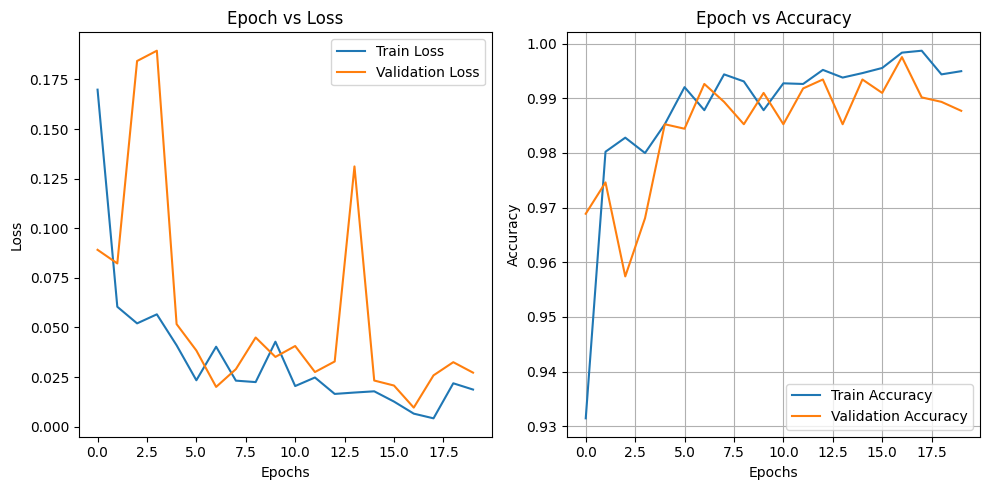

AttributeError: 'CustomResNet' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

<ipython-input-5-ae76e8f17af0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [13]:
if __name__ == "__main__":
    num_classes=3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize Model, Loss, and Optimizer
    model = CustomResNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train and validate model
    tvt(org_train_loader, org_val_loader, org_test_loader, model, criterion, optimizer, num_epochs=20)

In [14]:
criterion = nn.BCELoss()
all_labels, all_preds, misclassified_images = test_model(org_test_loader, "saved_model.pt", criterion)

<ipython-input-5-ae76e8f17af0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|██████████| 26/26 [00:06<00:00,  3.83it/s, Batch


Test Metrics:
--------------------------------------------------
Loss      : 0.0439
Accuracy  : 0.9881
Precision : 0.9857
Recall    : 0.9847
True Negatives : 1453
False Positives: 14
False Negatives: 15
True Positives : 963
F1 Score  : 0.9852
ROC AUC   : 0.9876
Metrics for class 0:
  Precision : 0.9528
  Recall    : 0.9528
  F1 Score  : 0.9528
  ROC AUC   : 0.9729
True Negatives : 704
False Positives: 5
False Negatives: 5
True Positives : 101
--------------------
Metrics for class 1:
  Precision : 0.9955
  Recall    : 0.9910
  F1 Score  : 0.9932
  ROC AUC   : 0.9946
True Negatives : 593
False Positives: 1
False Negatives: 2
True Positives : 219
--------------------
Metrics for class 2:
  Precision : 0.9877
  Recall    : 0.9877
  F1 Score  : 0.9877
  ROC AUC   : 0.9695
True Negatives : 156
False Positives: 8
False Negatives: 8
True Positives : 643
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95

In [15]:
# Test Model
def test_miss_model(test_loader, model_path, criterion):
    global num_classes
    global device
    # Initialize variables to store predictions and true labels

    # Load the model
    model = load_model(model_path)

    all_preds = []
    all_labels = []

    # Test loop
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct_predictions = 0

    # Initialize the progress bar for testing
    test_progress_bar = tqdm(test_loader, total=len(test_loader), desc='Testing', position=0, leave=True)

    misclassified_images = []

    with torch.no_grad():
        image_index = 0
        for images, labels, _ in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicts = (outputs > 0.5).float()

            # Check for misclassifications
            for idx, (img, pred, true) in enumerate(zip(images, predicts, labels)):
                if not torch.equal(pred, true):
                    misclassified_images.append({
                        'image_index': image_index + idx,  # Store the index
                        'image': img.cpu(),  # Store the image tensor
                        'predicted_labels': pred.cpu().numpy(),
                        'true_labels': true.cpu().numpy()
                    })

            # ... [rest of your existing code in the loop] ...
            # Store predictions and true labels for later metrics calculation
            all_preds.extend(predicts.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)

            test_loss = loss.item()
            test_running_loss += test_loss * images.size(0)
            test_correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            test_progress_bar.set_postfix({'Batch Loss': test_loss, 'Batch Accuracy': acc})

            image_index += images.size(0)

    # Calculate average loss and accuracy for the test set
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_accuracy = test_correct_predictions / len(test_loader.dataset)

    # Calculate other metrics
    precision = precision_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    recall = recall_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    f1 = f1_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    roc_auc = roc_auc_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    tn, fp, fn, tp = confusion_matrix(np.array(all_labels).flatten(), np.array(all_preds).flatten()).ravel()

    print("\n" + "="*50)
    print(f'Test Metrics:')
    print(f'{"-"*50}')
    print(f'Loss      : {test_epoch_loss:.4f}')
    print(f'Accuracy  : {test_epoch_accuracy:.4f}')
    print(f'Precision : {precision:.4f}')
    print(f'Recall    : {recall:.4f}')
    print(f'True Negatives : {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print(f'True Positives : {tp}')
    print(f'F1 Score  : {f1:.4f}')
    print(f'ROC AUC   : {roc_auc:.4f}')
    print("="*50)

    # Initialize variables to store class-wise metrics
    class_precisions = []
    class_recalls = []
    class_f1s = []
    class_roc_aucs = []

    # Calculate metrics for each class
    num_classes = np.array(all_labels).shape[1]  # Assuming all_labels is a 2D array
    for i in range(num_classes):
        y_true = np.array(all_labels)[:, i]
        y_pred = np.array(all_preds)[:, i]

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1)
        class_roc_aucs.append(roc_auc)

        print(f"Metrics for class {i}:")
        print(f"  Precision : {precision:.4f}")
        print(f"  Recall    : {recall:.4f}")
        print(f"  F1 Score  : {f1:.4f}")
        print(f"  ROC AUC   : {roc_auc:.4f}")
        print(f'True Negatives : {tn}')
        print(f'False Positives: {fp}')
        print(f'False Negatives: {fn}')
        print(f'True Positives : {tp}')
        print("-"*20)

    # If you want a summary report
    print("Summary Classification Report:")
    print(classification_report(np.array(all_labels), np.array(all_preds), zero_division=0))

    # Print or return the misclassified images
    print(f"Total Misclassified Images: {len(misclassified_images)}")
    for misclassified in misclassified_images:
        print(f"Image Index: {misclassified['image_index']}, Predicted Labels: {misclassified['predicted_labels']}, True Labels: {misclassified['true_labels']}")

    return all_labels, all_preds, misclassified_images

In [16]:
criterion = nn.BCELoss()
all_labels, all_preds, misclassified_images = test_miss_model(org_test_loader, "saved_model.pt", criterion)

<ipython-input-5-ae76e8f17af0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|██████████| 26/26 [00:06<00:00,  3.77it/s, Batch


Test Metrics:
--------------------------------------------------
Loss      : 0.0439
Accuracy  : 0.9881
Precision : 0.9857
Recall    : 0.9847
True Negatives : 1453
False Positives: 14
False Negatives: 15
True Positives : 963
F1 Score  : 0.9852
ROC AUC   : 0.9876
Metrics for class 0:
  Precision : 0.9528
  Recall    : 0.9528
  F1 Score  : 0.9528
  ROC AUC   : 0.9729
True Negatives : 704
False Positives: 5
False Negatives: 5
True Positives : 101
--------------------
Metrics for class 1:
  Precision : 0.9955
  Recall    : 0.9910
  F1 Score  : 0.9932
  ROC AUC   : 0.9946
True Negatives : 593
False Positives: 1
False Negatives: 2
True Positives : 219
--------------------
Metrics for class 2:
  Precision : 0.9877
  Recall    : 0.9877
  F1 Score  : 0.9877
  ROC AUC   : 0.9695
True Negatives : 156
False Positives: 8
False Negatives: 8
True Positives : 643
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Dataset for Inference
class InferenceDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        # Collecting image paths with a debug message
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith(".JPG")]
        if not self.image_paths:
            print(f"No images found in {root_dir}. Please check the directory path and file extensions.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Return path as well for identification

# Function to Generate Predictions
def generate_predictions(model_path, inference_folder):
    # Load the saved model and move it to the device
    model = torch.load(model_path, map_location=device)
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1006, 0.1011, 0.1009], std=[0.0998, 0.0999, 0.0985])
    ])

    # Initialize dataset and dataloader
    inference_dataset = InferenceDataset(root_dir=inference_folder, transform=transform)
    inference_loader = DataLoader(inference_dataset, batch_size=32, shuffle=False)

    predictions = []
    with torch.no_grad():
        for images, img_paths in tqdm(inference_loader, desc='Generating Predictions'):
            images = images.to(device)
            outputs = model(images)

            # Convert predictions to binary values
            preds = (outputs > 0.5).float().cpu().numpy()

            # Collect predictions and corresponding image paths
            for img_path, pred in zip(img_paths, preds):
                predictions.append({
                    "image_path": img_path,
                    "predicted_labels": pred
                })

    if not predictions:
        print("No predictions generated. Please check if the dataset is loading images correctly.")
    return predictions

# Folder containing new images for inference
inference_folder = "/content/drive/MyDrive/Capstone: CV for Infant Lumbar Puncture/Data Files/Images to Predict"
model_path = "saved_model.pt"  # Path to your saved model

# Generate predictions
predictions = generate_predictions(model_path, inference_folder)

# Display predictions
for pred in predictions:
    print(f"Image: {pred['image_path']}, Predicted Labels: {pred['predicted_labels']}")


<ipython-input-17-c105080d604a>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)
Generating Predictions: 100%|██████████

Image: /content/drive/MyDrive/Capstone: CV for Infant Lumbar Puncture/Data Files/Images to Predict/IMG_0254.JPG, Predicted Labels: [0. 1. 1.]
Image: /content/drive/MyDrive/Capstone: CV for Infant Lumbar Puncture/Data Files/Images to Predict/IMG_0255.JPG, Predicted Labels: [0. 1. 1.]
Image: /content/drive/MyDrive/Capstone: CV for Infant Lumbar Puncture/Data Files/Images to Predict/IMG_0266.JPG, Predicted Labels: [0. 0. 1.]
Image: /content/drive/MyDrive/Capstone: CV for Infant Lumbar Puncture/Data Files/Images to Predict/IMG_0267.JPG, Predicted Labels: [0. 1. 1.]
Image: /content/drive/MyDrive/Capstone: CV for Infant Lumbar Puncture/Data Files/Images to Predict/IMG_0268.JPG, Predicted Labels: [0. 1. 1.]
Image: /content/drive/MyDrive/Capstone: CV for Infant Lumbar Puncture/Data Files/Images to Predict/IMG_0271.JPG, Predicted Labels: [0. 0. 1.]
Image: /content/drive/MyDrive/Capstone: CV for Infant Lumbar Puncture/Data Files/Images to Predict/IMG_0277.JPG, Predicted Labels: [0. 1. 1.]
Image:

In [19]:
d = {"filename":[], "BAD QUALITY":[], "CORD":[], "FLUID":[]}
for pred in predictions:
    d["filename"].append(os.path.basename(pred['image_path']))
    d["BAD QUALITY"].append(pred['predicted_labels'][0])
    d["CORD"].append(pred['predicted_labels'][1])
    d["FLUID"].append(pred['predicted_labels'][2])

df = pd.DataFrame(d)
df.head()

,filename,BAD QUALITY,CORD,FLUID
0,IMG_0254.JPG,0.0,1.0,1.0
1,IMG_0255.JPG,0.0,1.0,1.0
2,IMG_0266.JPG,0.0,0.0,1.0
3,IMG_0267.JPG,0.0,1.0,1.0
4,IMG_0268.JPG,0.0,1.0,1.0


In [20]:
df.to_csv('predictions_ResNET18.csv', index=False)

In [ ]:
#function for all missclassified images

import matplotlib.pyplot as plt
import math

def show_misclassified_images(misclassified_images):
    num_images = len(misclassified_images)
    num_cols = 5  # You can adjust the number of columns
    num_rows = math.ceil(num_images / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

    for i in range(num_images):
        img_info = misclassified_images[i]
        img = img_info['image'].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        predicted = img_info['predicted_labels']
        true = img_info['true_labels']
        index = img_info['image_index']  # Get the image index

        ax = axs[i // num_cols, i % num_cols]  # Determine row and column position
        ax.imshow(img)
        ax.set_title(f"Index: {index}\nPred: {predicted}\nTrue: {true}")
        ax.axis('off')

    # Hide any unused subplots
    for i in range(num_images, num_rows * num_cols):
        axs[i // num_cols, i % num_cols].axis('off')

    plt.show()


In [ ]:
# Now display the misclassified images
show_misclassified_images(misclassified_images)

In [ ]:
#calling all misclassified images

show_misclassified_images(misclassified_images)

In [ ]:
def calculate_fp_fn(misclassified_images, num_classes):
    # Initialize counters
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    # Analyze each misclassified image
    for img_info in misclassified_images:
        predicted_labels = img_info['predicted_labels']
        true_labels = img_info['true_labels']

        for i in range(num_classes):
            # False positive: predicted is 1, true is 0
            if predicted_labels[i] == 1 and true_labels[i] == 0:
                false_positives[i] += 1
            # False negative: predicted is 0, true is 1
            elif predicted_labels[i] == 0 and true_labels[i] == 1:
                false_negatives[i] += 1

    return false_positives, false_negatives

# Call this function after you have the misclassified_images list
false_positives, false_negatives = calculate_fp_fn(misclassified_images, 3)

# Print the results
print("False Positives per Class:", false_positives)
print("False Negatives per Class:", false_negatives)


False Positives per Class: [11, 0, 0]

For the first class (let's call it Class 1), your model incorrectly predicted the positive label (predicted as '1') 11 times when the true label was negative (actual '0'). This means there were 11 instances where the model thought the feature corresponding to Class 1 was present, but it actually wasn't.
For the second and third classes (Class 2 and Class 3), there were no false positives. This means the model never incorrectly predicted the presence of these features; it did not mistakenly identify these features in any of the images where they were actually absent.
False Negatives per Class: [0, 3, 10]

For Class 1, there were no false negatives. This means that whenever the feature corresponding to Class 1 was present in an image, the model always identified it correctly.
For Class 2, there were 3 instances where the model failed to identify the presence of the feature (predicted as '0') when it was actually present (true '1'). In other words, the model missed this feature 3 times when it should have detected it.
For Class 3, the situation is more pronounced with 10 false negatives. This indicates that the model frequently failed to recognize the presence of the feature corresponding to Class 3.

In [ ]:
def filter_specific_misclassifications(misclassified_images):
    filtered_images = []
    for img_info in misclassified_images:
        true_labels = img_info['true_labels']
        predicted_labels = img_info['predicted_labels']
        # Check if Class 1 is '1' and Class 2 & 3 are '0' in true labels
        # and if Class 1 is correctly predicted as '1'
        if true_labels[0] == 1 and true_labels[1] == 0 and true_labels[2] == 0 and predicted_labels[0] == 1:
            filtered_images.append(img_info)
    return filtered_images

specific_misclassifications = filter_specific_misclassifications(misclassified_images)

def show_filtered_images(filtered_images, num_cols=5):
    num_images = len(filtered_images)
    if num_images == 0:
        print("No images meet the specified criteria.")
        return

    num_rows = math.ceil(num_images / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

    for i, img_info in enumerate(filtered_images):
        img = img_info['image'].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        predicted = img_info['predicted_labels']
        true = img_info['true_labels']

        # Handle the case when axs is 1-dimensional
        if num_images <= num_cols:
            ax = axs[i]  # Index as a 1D array
        else:
            ax = axs[i // num_cols, i % num_cols]  # Index as a 2D array

        ax.imshow(img)
        ax.set_title(f"Pred: {predicted}\nTrue: {true}")
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        if num_images <= num_cols:
            axs[j].axis('off')  # Index as a 1D array
        else:
            axs[j // num_cols, j % num_cols].axis('off')  # Index as a 2D array

    plt.show()

In [ ]:
# Filter and show the specific misclassifications
show_filtered_images(specific_misclassifications)

In [ ]:
def filter_specific_predictions(misclassified_images):
    filtered_images = []
    for img_info in misclassified_images:
        predicted_labels = img_info['predicted_labels']
        # Check if predicted Class 1 is '1' and Classes 2 & 3 are '0'
        if predicted_labels[0] == 1 and predicted_labels[1] == 0 and predicted_labels[2] == 0:
            filtered_images.append(img_info)
    return filtered_images

specific_predictions = filter_specific_predictions(misclassified_images)

import matplotlib.pyplot as plt
import math

def show_filtered_images(filtered_images, num_cols=5):
    num_images = len(filtered_images)
    if num_images == 0:
        print("No images meet the specified criteria.")
        return

    num_rows = math.ceil(num_images / num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
    # If there's only one row, axs will be 1D, so we need to handle this case
    if num_rows == 1:
        axs = [axs]  # Make axs a list of lists

    for i, img_info in enumerate(filtered_images):
        img = img_info['image'].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        predicted = img_info['predicted_labels']
        true = img_info['true_labels']
        ax = axs[i // num_cols][i % num_cols] # Access the correct element now that axs is 2D
        ax.imshow(img)
        ax.set_title(f"Pred: {predicted}\nTrue: {true}")
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        axs[j // num_cols][j % num_cols].axis('off')  # Access correctly

    plt.show()

In [ ]:
# Filter and show the specific predictions
show_filtered_images(specific_predictions)